In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# blocks output in Colab 💄
%%capture
!unzip '/content/gdrive/MyDrive/CV Data/Garbage Data.zip'

In [4]:
data_dir  = 'Garbage Data/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
classes = [i for i in classes if not i.startswith('.')]
print(classes)

['metal', 'plastic', 'cardboard', 'glass', 'paper', 'trash']


# Apply Transformation

Resize all images into 256 x 256

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [6]:
random_seed = 1337
torch.manual_seed(random_seed)

#View Some Sample Images

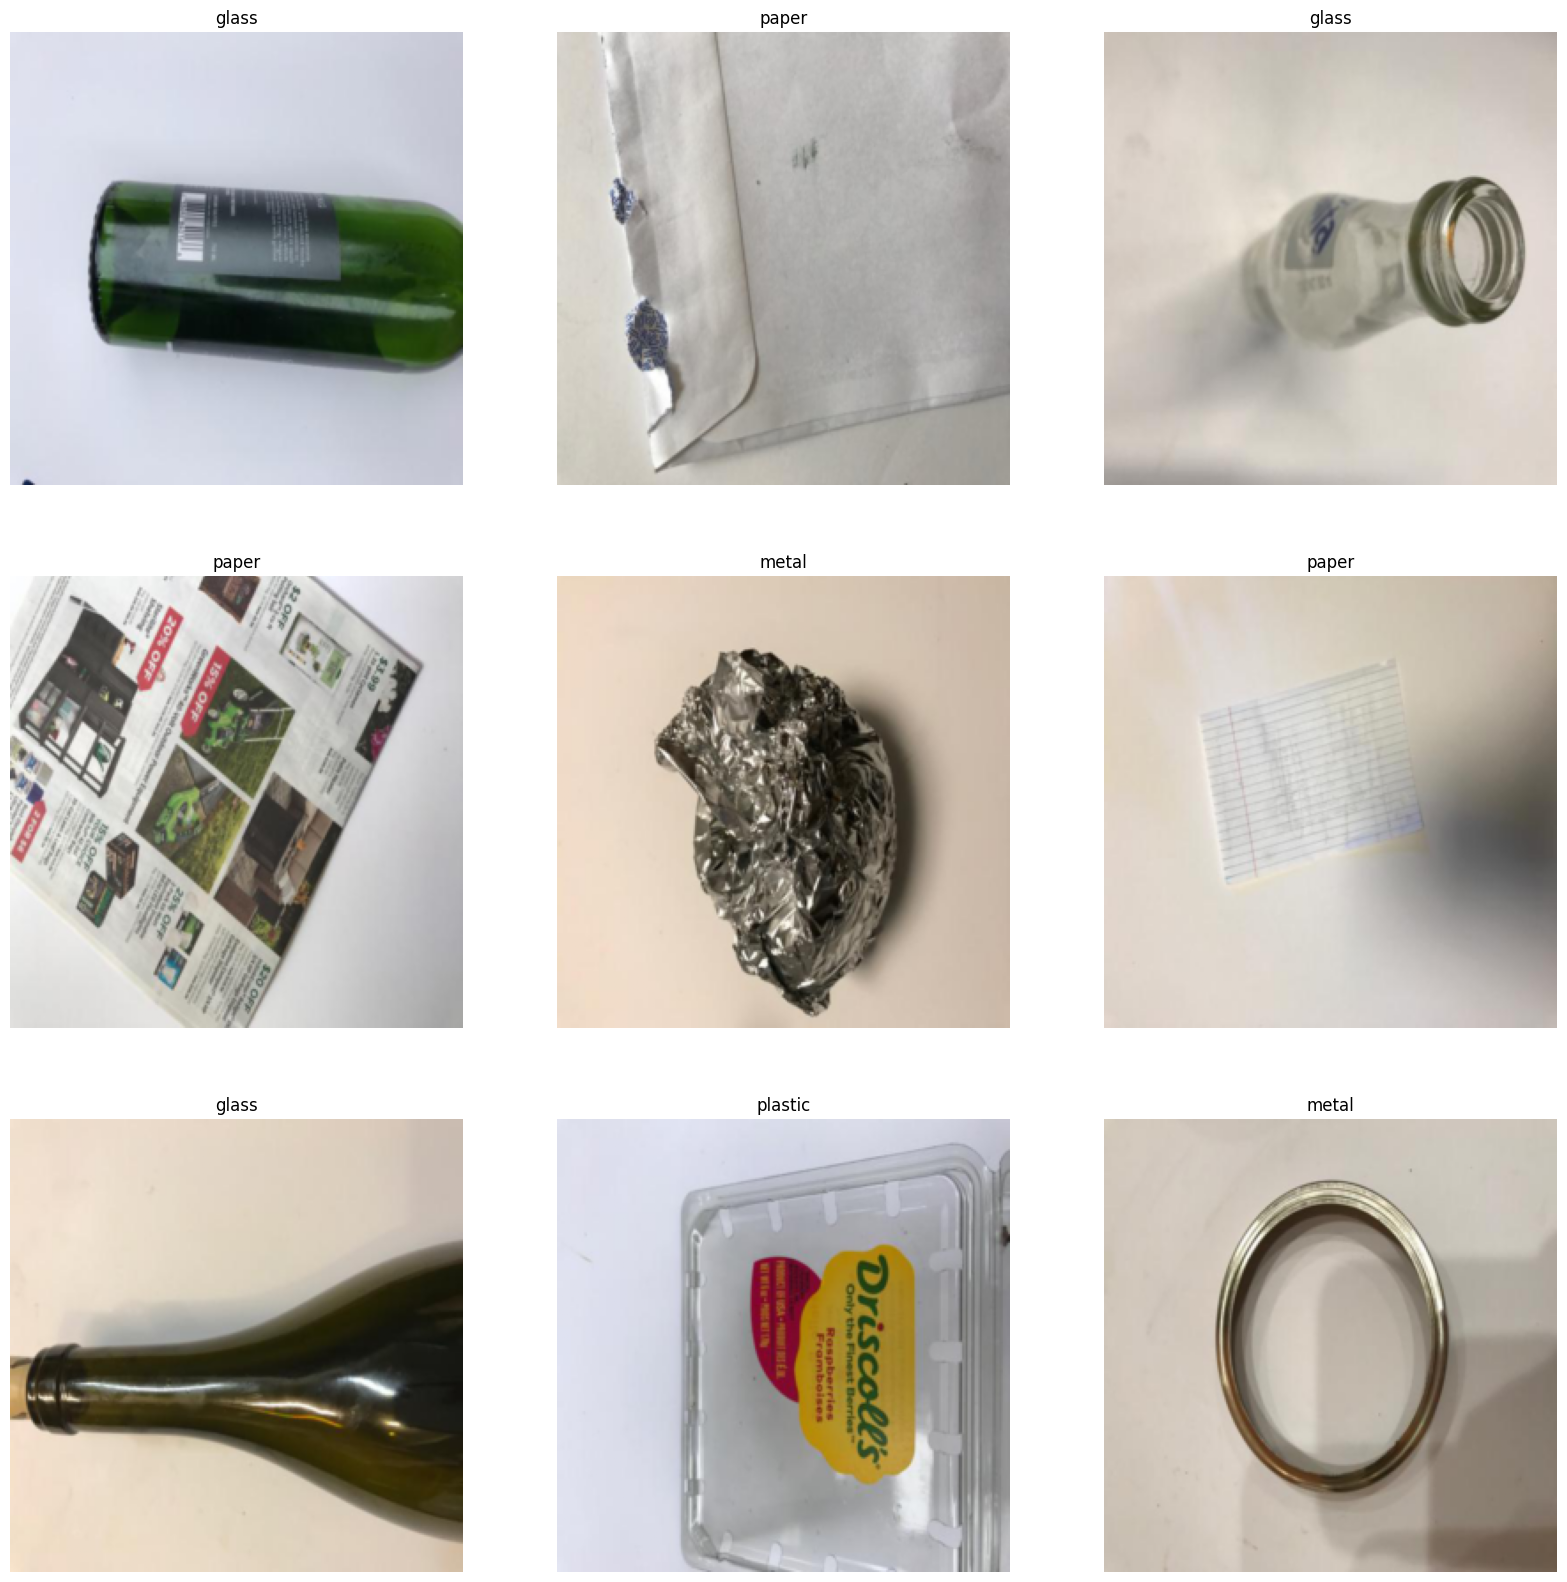

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(3,3, figsize=(20, 20))
axs = axs.flatten()
for i in range(9):
    idx = torch.randint(len(dataset), size=(1,)).item()
    img = dataset[idx][0]
    label = dataset[idx][1]
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(dataset.classes[label])
    axs[i].axis('off')

#split data

In [8]:

train_ds, val_ds, test_ds = random_split(dataset, [0.7, 0.2, 0.1])
len(train_ds), len(val_ds), len(test_ds)

(1769, 506, 252)

In [9]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

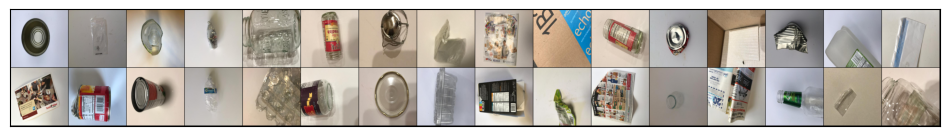

In [11]:
show_batch(train_dl)

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
class ResNet(ImageClassificationBase):
  #inherit from ImageClassificationBase
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
model = ResNet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [19]:
import os
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    checkpoint_interval = 5
    epoch_checkpoint = 0
    Path = os.path.join(os.getcwd(),'Model Checkpoints')
    os.makedirs(Path,exist_ok = True)
    if len(os.listdir(Path))>1:
      checkpoint = sorted(os.listdir(Path))[-1]
      checkpoint = torch.load(os.path.join(Path,checkpoint))
      epoch_checkpoint = checkpoint['epoch']
      model.load_state_dict(checkpoint['model_state'])
      optimizer.load_state_dict(checkpoint['optim_state'])

    for epoch in range(epoch_checkpoint,epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        #save checkpoint after every 5 epochs and end of the iteration
        if (epoch+1) % checkpoint_interval == 0 or epoch+1 == epochs:
          checkpoint = {
                        "epoch": epoch+1,
                        "model_state": model.state_dict(),
                        "optim_state": optimizer.state_dict(),
                        }
          torch.save(checkpoint, os.path.join(Path,f'Checkpoint{epoch+1}.pth'))
    return history

In [20]:
#before training
evaluate(model, val_dl)

{'val_loss': 1.7757066488265991, 'val_acc': 0.1396821141242981}

In [21]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4478, val_loss: 1.2276, val_acc: 0.8777
Epoch 2: train_loss: 1.1748, val_loss: 1.1429, val_acc: 0.9328
Epoch 3: train_loss: 1.1034, val_loss: 1.1265, val_acc: 0.9347
Epoch 4: train_loss: 1.0720, val_loss: 1.1025, val_acc: 0.9506
Epoch 5: train_loss: 1.0693, val_loss: 1.1068, val_acc: 0.9451
Epoch 6: train_loss: 1.0634, val_loss: 1.1009, val_acc: 0.9527
Epoch 7: train_loss: 1.0578, val_loss: 1.0985, val_acc: 0.9506
Epoch 8: train_loss: 1.0566, val_loss: 1.0953, val_acc: 0.9506


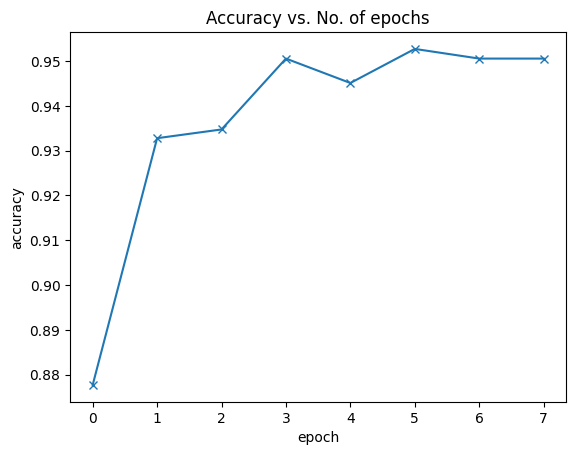

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

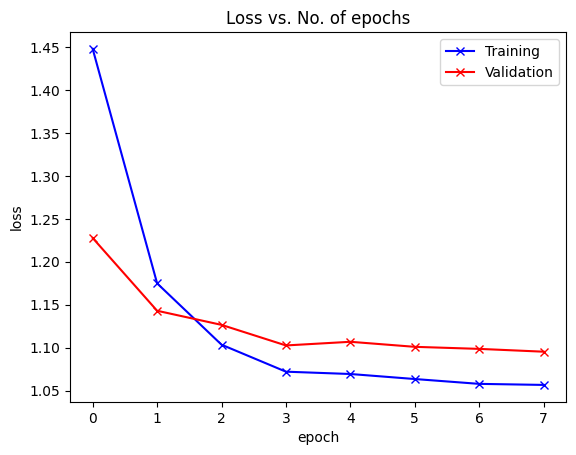

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [24]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

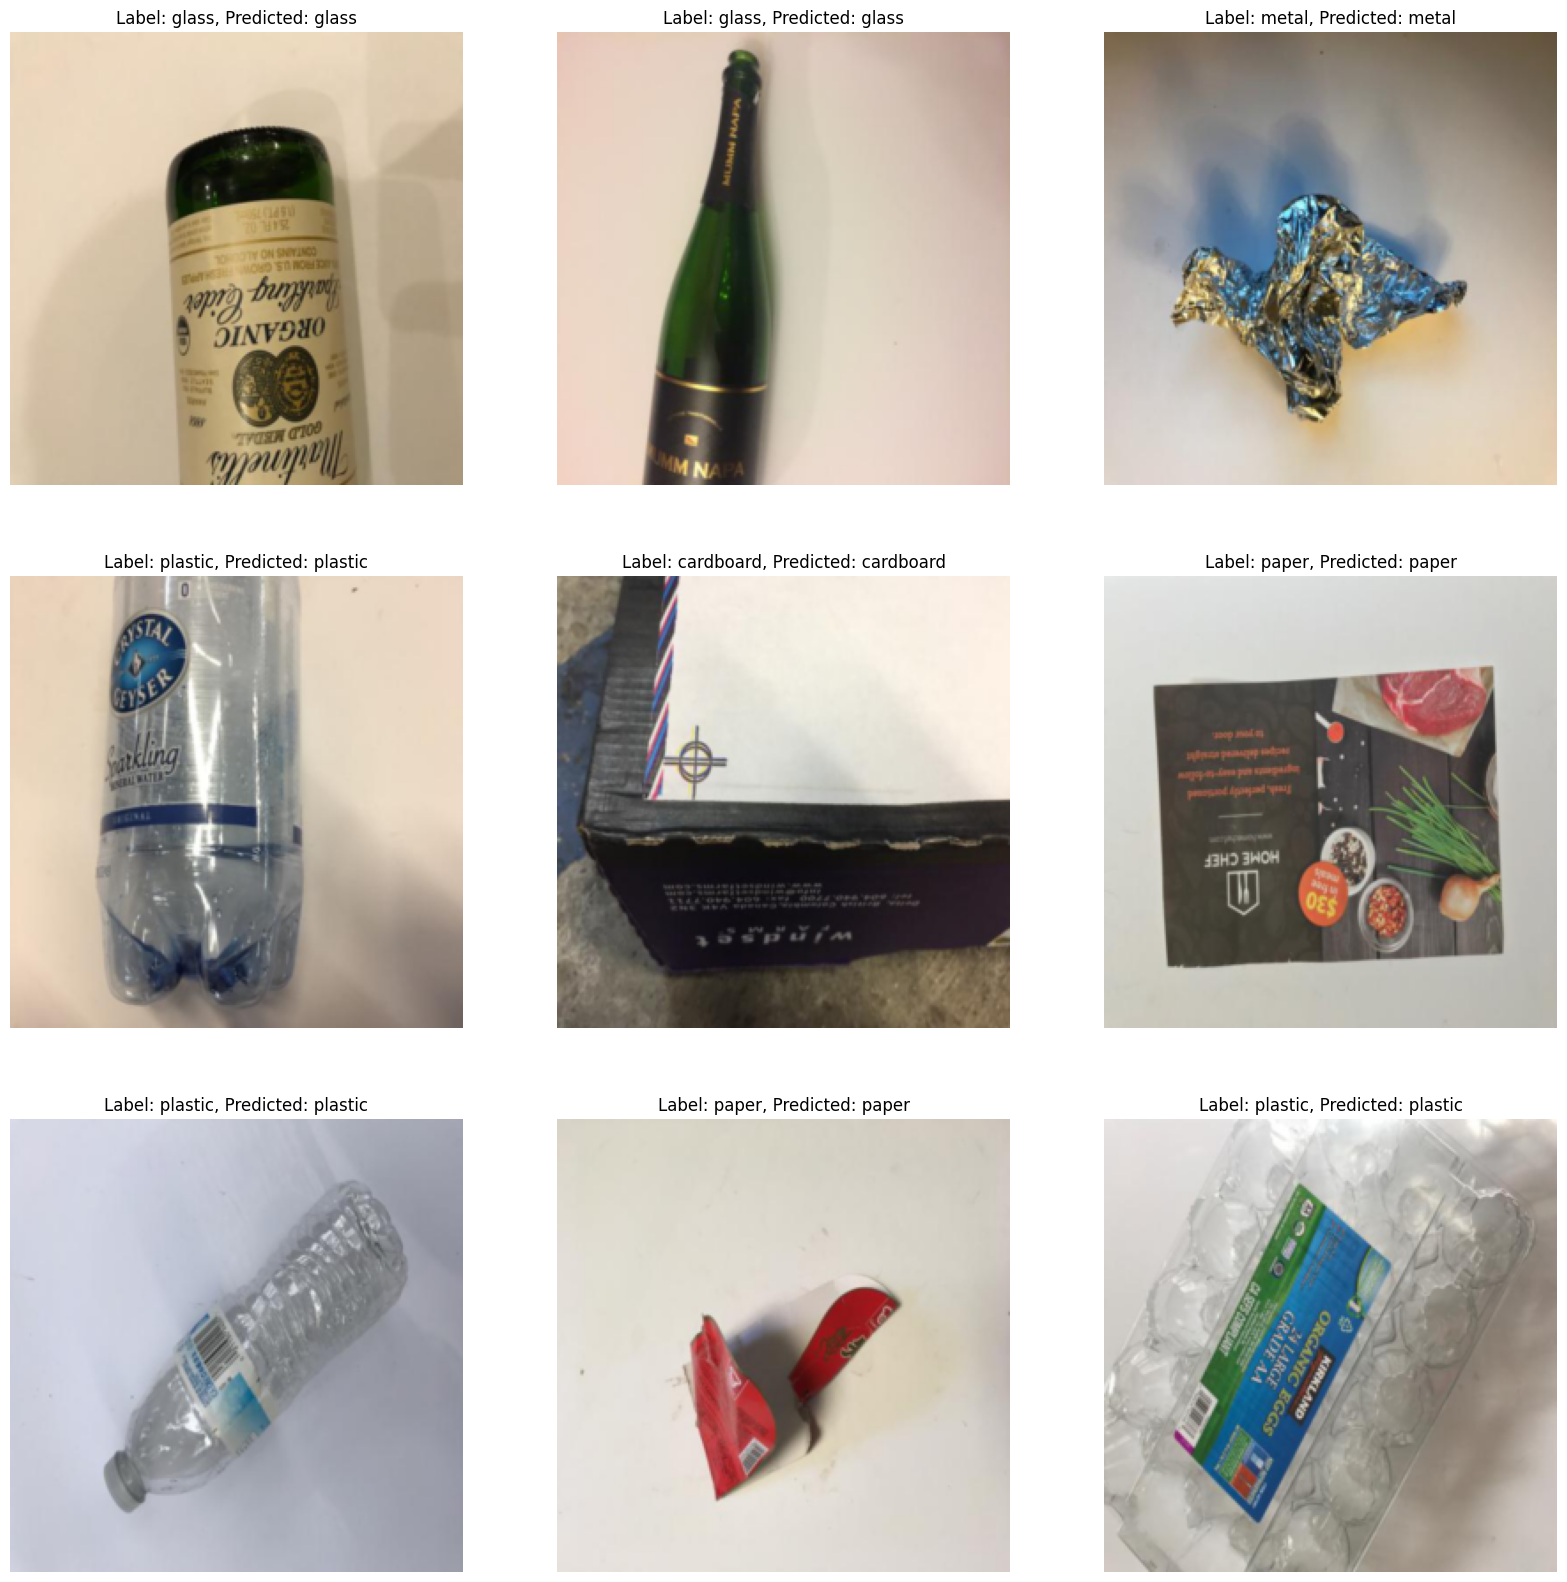

In [29]:
fig, axs = plt.subplots(3,3, figsize=(20, 20))
axs = axs.flatten()
for i in range(9):
  idx = torch.randint(len(test_ds), size=(1,)).item()
  img, label = test_ds[idx]
  axs[i].imshow(img.permute(1, 2, 0))
  tlt = f'Label: {dataset.classes[label]}, Predicted: {predict_image(img, model)}'
  axs[i].set_title(tlt)
  axs[i].axis('off')

